<h1>FINAL PIPELINE</h1>

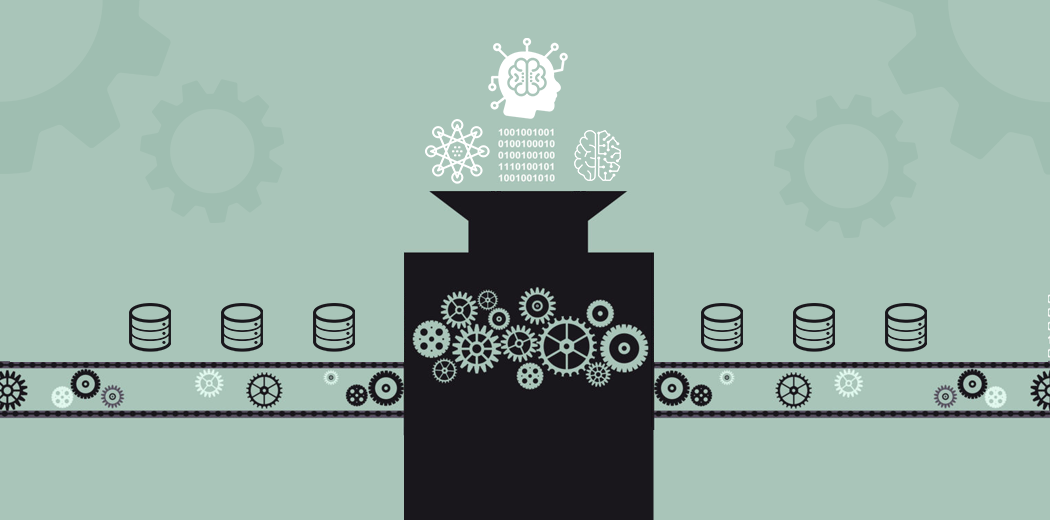

<pre>This Ipython NoteBook is for the Final Pipeline of the whole project. It includes the process from Raw Input to Final Prediction.
It consists of a Class named final_pipeline, which does all this inside. It starts by loading the required files and models into the memory, takes the input, cleans it, pre-processes it and then returns the predicted output.
There are two functions in this class.
1. Function 1 just takes 1 input and returns the predicted probability and the class label.
2. Function 2 may take more than 1 input datapoint, along with the Acutal Class Label. If there are more than 1 datapoints, it predicts the output, and compares with the Actual Class label and returns the Predicted Output along with the Metric.

## Loading Libraries and Packages

In [1]:
#importing Useful DataStructures
import pandas as pd
import numpy as np

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## Defining Final Pipeline

In [2]:
class final_pipeline:
    '''
    Final Pipeline for Prediction of Test Datapoints
    
    Contains 5 member Functions:
        1. init method
        2. load_required_files method
        3. preprocessing method
        4. final_function_1 method
        5. final_function_2 method
    '''
    
    def __init__(self, file_directory = ''):
        '''
        This function is used to initialize the Class members. It also loads up the required files for pre-processing and predictions
        once instantiated.
        
        Inputs:
            self
            file_directory: str, default = ''
                Path of the directory where the file is stored
        
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.load_required_files()
        
    def load_required_files(self):
        '''
        Function to load all the required files for Pre-processing and prediction. Gets called when the 
        class gets initialized
        
        Inputs:
            self
            
        Returns:
            Pre-processed DataFrame
        '''
        
        #loading important files
        with open(self.file_directory + 'relational_table.pkl', 'rb') as f:
            self.relational_table = pickle.load(f)
        #loading final columns list
        with open(self.file_directory + 'Final_XGBOOST_Selected_features.pkl', 'rb') as f:
            self.final_cols = pickle.load(f)
        #loading te columns for modelling for ext_sources
        with open(self.file_directory + 'columns_for_ext_values_predictor.pkl', 'rb') as f:
            self.columns_for_modelling = pickle.load(f)
        #loading XGBRegressor models for predicting missing EXT_SOURCE fields
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_1_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_1 = pickle.load(f)
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_2_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_2 = pickle.load(f)
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_3_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_3 = pickle.load(f)
        #loading LGBMRegressor model for predicting Count Payments for data
        with open(self.file_directory + 'cnt_payment_predictor_lgbmr.pkl', 'rb') as f:
            self.cnt_payment_lgbmr = pickle.load(f)
        #loading the training target values
        with open(self.file_directory + 'Train_TARGET.pkl', 'rb') as f:
            self.TARGET = pickle.load(f)
        #loading KNN model for TARGET_500_neighbors feature
        with open(self.file_directory + 'KNN_model_TARGET_500_neighbors.pkl', 'rb') as f:
            self.knn_target_500_neighbors = pickle.load(f)
        #loading grouped interactions for several groupings
        file_names = ['Application_train_grouped_interactions_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl',
                      'Application_train_grouped_interactions_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE.pkl',
                      'Application_train_grouped_interactions_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE.pkl',
                      'Application_train_grouped_interactions_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl',
                      'Application_train_grouped_interactions_OCCUPATION_TYPE_ORGANIZATION_TYPE.pkl',
                      'Application_train_grouped_interactions_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY.pkl']
        self.group_interactions_tables = []
        for group_interactions_file_name in file_names:
            with open(self.file_directory + 'Grouped Interactions/' + group_interactions_file_name, 'rb') as f:
                self.group_interactions_tables.append(pickle.load(f))
        
        #loading final model for prediction
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_1_model_600feats.pkl', 'rb') as f:
            self.final_xgb_1 = pickle.load(f)
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_2_model_600feats.pkl', 'rb') as f:
            self.final_xgb_2 = pickle.load(f)
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_3_model_600feats.pkl', 'rb') as f:
            self.final_xgb_3 = pickle.load(f)
        #threshold for class label
        self.threshold = 0.04579606279730797
    
    def preprocessing(self, data):
        '''
        Function to preprocess the data into required format for predictions
        
        Inputs:
            self
            data: DataFrame
                The Test DataFrame
            
        Returns:
            None        
        '''
        
        #dropping flag columns
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                    'FLAG_DOCUMENT_20']
        data = data.drop(flag_cols_to_drop, axis = 1)
        #converting age to years
        data['DAYS_BIRTH'] = data['DAYS_BIRTH'] * -1 / 365
        #removing erroneous points
        data['DAYS_EMPLOYED'][data['DAYS_EMPLOYED'] == 365243] = np.nan
        data['OBS_30_CNT_SOCIAL_CIRCLE'][data['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        data['OBS_60_CNT_SOCIAL_CIRCLE'][data['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #filling NaN values for categorical columns with 'XNA'
        categorical_columns = data.dtypes[data.dtypes == 'object'].index.tolist()
        data[categorical_columns] = data[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type
        data['REGION_RATING_CLIENT'] = data['REGION_RATING_CLIENT'].astype('object')
        data['REGION_RATING_CLIENT_W_CITY'] = data['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        data['MISSING_VALS_TOTAL_APP'] = data.isna().sum(axis = 1)
        
        #we need to predict missing EXT_SOURCE Values if any
        columns_for_modelling = self.columns_for_modelling
        #defining the list of models
        xgbr_ext_models = [self.xgbr_ext_2, self.xgbr_ext_3, self.xgbr_ext_1]
        for index, ext_col in enumerate(['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']):
            #checking if the value is missing or not
            if data[ext_col].isna().sum() > 0:
                X_test_missing = data[data[ext_col].isna()][columns_for_modelling]
                data[ext_col][data[ext_col].isna()] = xgbr_ext_models[index].predict(X_test_missing)
                
            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]
        
        #creating numeric features
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        #we need to predict count_payment for our given data
        test_data = data[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        cnt_payment = self.cnt_payment_lgbmr.predict(test_data)
        del test_data
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
        
        #predicting the mean of TARGET of 500 neighbors of test data
        test_data_for_neighbors = data[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        test_500_neighbors = self.knn_target_500_neighbors.kneighbors(test_data_for_neighbors)[1]
        data['TARGET_NEIGHBORS_500_MEAN'] = [self.TARGET.iloc[ele].mean() for ele in test_500_neighbors]

        #creating features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
        ]
        for index, group in enumerate(columns_to_aggregate_on):
            group_stats = self.group_interactions_tables[index]
            data = data.join(group_stats, on = group)
        
        #response coding for categorical columns
        categorical_columns = data.dtypes[data.dtypes == 'object'].index.tolist()
        for col in categorical_columns:
            #loading the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            with open(self.file_directory + 'Response Coding/' + f'Response_coding_dict_{col}.pkl', 'rb') as f:
                mapping_dictionary_column = pickle.load(f)
            #mapping this dictionary with our DataFrame
            data[col + '_0'] = data[col].map(mapping_dictionary_column[0])
            data[col + '_1'] = data[col].map(mapping_dictionary_column[1])
            #removing the original categorical columns
            _ = data.pop(col)
            
        #merging with the relational table
        data = data.merge(self.relational_table, on = 'SK_ID_CURR', how = 'left')

        #adding features based on interactions between different tables
        
        #previous_application columns
        prev_annuity_columns =  ['AMT_ANNUITY_MEAN_LAST_5', 'AMT_ANNUITY_SUM_LAST_5', 'AMT_ANNUITY_MAX_LAST_5', 'AMT_ANNUITY_MEAN_FIRST_2',
                                 'AMT_ANNUITY_SUM_FIRST_2', 'AMT_ANNUITY_MAX_FIRST_2', 'AMT_ANNUITY_MEAN_ALL', 'AMT_ANNUITY_SUM_ALL', 'AMT_ANNUITY_MAX_ALL']
        for col in prev_annuity_columns:
            data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        prev_goods_columns = ['AMT_GOODS_PRICE_MEAN_LAST_5', 'AMT_GOODS_PRICE_MAX_LAST_5', 'AMT_GOODS_PRICE_SUM_LAST_5', 'AMT_GOODS_PRICE_MEAN_FIRST_2',
                              'AMT_GOODS_PRICE_MAX_FIRST_2', 'AMT_GOODS_PRICE_SUM_FIRST_2', 'AMT_GOODS_PRICE_MEAN_ALL', 'AMT_GOODS_PRICE_MAX_ALL',
                              'AMT_GOODS_PRICE_SUM_ALL']
        for col in prev_goods_columns:
            data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)       
        #credit_card_balance columns
        cc_amt_principal_cols = ['AMT_RECEIVABLE_PRINCIPAL_SUM', 'AMT_RECEIVABLE_PRINCIPAL_MEAN', 'AMT_RECEIVABLE_PRINCIPAL_MAX', 'EXP_AMT_RECEIVABLE_PRINCIPAL_LAST']
        for col in cc_amt_principal_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        cc_amt_recivable_cols = ['AMT_RECIVABLE_SUM', 'AMT_RECIVABLE_MEAN', 'AMT_RECIVABLE_MAX', 'EXP_AMT_RECIVABLE_LAST']
        for col in cc_amt_recivable_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        cc_amt_total_receivable_cols = ['AMT_TOTAL_RECEIVABLE_SUM', 'AMT_TOTAL_RECEIVABLE_MEAN', 'AMT_TOTAL_RECEIVABLE_MAX', 'EXP_AMT_TOTAL_RECEIVABLE_LAST']
        for col in cc_amt_total_receivable_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        #installments_payments columns
        installments_payment_cols = ['AMT_PAYMENT_MEAN_MEAN', 'AMT_PAYMENT_MEAN_SUM', 'AMT_PAYMENT_MEAN_MAX', 'AMT_PAYMENT_SUM_MEAN', 'AMT_PAYMENT_SUM_SUM',
                                     'AMT_PAYMENT_SUM_MAX', 'AMT_PAYMENT_MAX_MEAN', 'AMT_PAYMENT_MEAN_LAST_1_YEAR', 'AMT_PAYMENT_SUM_LAST_1_YEAR',
                                     'AMT_PAYMENT_MAX_LAST_1_YEAR', 'AMT_PAYMENT_MEAN_FIRST_5_INSTALLMENTS', 'AMT_PAYMENT_SUM_FIRST_5_INSTALLMENTS',
                                     'AMT_PAYMENT_MAX_FIRST_5_INSTALLMENTS']
        for col in installments_payment_cols:
            data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
        for col in installments_max_installment:
            data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)
        #bureau and bureau_balance columns
        bureau_days_credit_cols = ['DAYS_CREDIT_MEAN_OVERALL', 'DAYS_CREDIT_MEAN_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_MIN_CREDITACTIVE_CLOSED',
                                   'DAYS_CREDIT_MAX_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_LAST_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_MEAN_CREDITACTIVE_ACTIVE',
                                   'DAYS_CREDIT_MIN_CREDITACTIVE_ACTIVE', 'DAYS_CREDIT_MAX_CREDITACTIVE_ACTIVE', 'DAYS_CREDIT_LAST_CREDITACTIVE_ACTIVE',
                                   'DAYS_CREDIT_MEANCREDIT_ACTIVE_REST', 'DAYS_CREDIT_MINCREDIT_ACTIVE_REST', 'DAYS_CREDIT_MAXCREDIT_ACTIVE_REST',
                                   'DAYS_CREDIT_LASTCREDIT_ACTIVE_REST']
        for col in bureau_days_credit_cols:
            data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
            data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
        bureau_overdue_cols = ['AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL', 'AMT_CREDIT_SUM_OVERDUE_MEAN_OVERALL', 'AMT_CREDIT_MAX_OVERDUE_MAX_CREDITACTIVE_CLOSED',
                               'AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED', 'AMT_CREDIT_SUM_OVERDUE_MAX_CREDITACTIVE_CLOSED', 'AMT_CREDIT_SUM_OVERDUE_SUM_CREDITACTIVE_CLOSED',
                               'AMT_CREDIT_MAX_OVERDUE_MAX_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_SUM_OVERDUE_MAX_CREDITACTIVE_ACTIVE',
                                'AMT_CREDIT_SUM_OVERDUE_SUM_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE_MAXCREDIT_ACTIVE_REST', 'AMT_CREDIT_MAX_OVERDUE_SUMCREDIT_ACTIVE_REST',
                               'AMT_CREDIT_SUM_OVERDUE_MAXCREDIT_ACTIVE_REST', 'AMT_CREDIT_SUM_OVERDUE_SUMCREDIT_ACTIVE_REST']
        for col in bureau_overdue_cols:
            data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        bureau_amt_annuity_cols = ['AMT_ANNUITY_MEAN_OVERALL']
        for col in bureau_amt_annuity_cols:
            data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)  
            
        #removing some non-useful features
        data = data[self.final_cols]
        
        gc.collect()
        
        return data
    
    def final_function_1(self, input_data):
        '''
        Function 1 for prediction. This function takes one argument that is the test datapoint, and prints the prediction for that point.
        
        Inputs:
            self
            input_data: DataFrame
                The test datapoint, whose Target is to be predicted
        
        Returns:
            None
        '''
        
        start_time = datetime.now()
        #first preprocessing it
        test_data = self.preprocessing(input_data)
        #making the predictions
        test_predicted_probability = np.zeros(len(input_data))
        for model in [self.final_xgb_1, self.final_xgb_2, self.final_xgb_3]:
            test_predicted_probability += model.predict_proba(test_data, ntree_limit = model.get_booster().best_ntree_limit)[:,1] / 3
        predicted_class_label = np.where(test_predicted_probability > self.threshold, 1, 0)
        
        #printing the results
        print("-" * 100)
        print(f"Predicted Probabilties for given Client(s) being Defaulter is/are: {np.round(test_predicted_probability, 4)}")
        print(f"The class label for given query point is: {predicted_class_label}")
        print(f"Total Time Taken for prediction = {datetime.now() - start_time}")
        print('-' * 100)
        
    def final_function_2(self, input_data, target):
        '''
        Function 2 for prediction. This function takes both the Test Point and Target value of that point. It returns
        the prediction along with the metric for the predicted points.
        
        Inputs:
            self
            input_data: DataFrame
                Test Datapoint
            target: Series
                Target value corresponding to test points
        
        Returns:
            None
        '''
        
        start_time = datetime.now()
        #first preprocessing the input data
        test_data = self.preprocessing(input_data)
        
        #making predictions
        test_predicted_probability = np.zeros(input_data.shape[0])
        for model in [self.final_xgb_1, self.final_xgb_2, self.final_xgb_3]:
            test_predicted_probability += model.predict_proba(test_data, ntree_limit = model.get_booster().best_ntree_limit)[:,1] / 3

        print("-" * 100)
        print(f"Predicted Probabilties for given Client(s) being Defaulter is/are:\n{np.round(test_predicted_probability, 4)}")
        predicted_classes = np.where(test_predicted_probability > self.threshold, 1, 0)
        print(f"\nThe predicted class labels are:\n{predicted_classes}")
        #if there are more than 1 input, printing the Metrics
        if len(input_data)>1:
            print('-' * 100)
            print("\nThe Performance Metrics are:\n")
            try:
                print(f"ROC-AUC Score = {roc_auc_score(target, test_predicted_probability)}")
            except:
                print("Cannot calculate ROC-AUC Score as the Test Datapoints have only 1 type of Class Labels present. Try with different Datapoints")
            print(f"Recall Score = {recall_score(target, predicted_classes)}")
        print(f"Total Time taken for prediction = {datetime.now() - start_time}")
        print("-" * 100)

## Getting the output

Let us first load some test and training datapoint, to test out final pipeline.

In [3]:
train_data = pd.read_csv('application_train.csv')
test_data = pd.read_csv('application_test.csv')

Creating the Object of Final Pipeline.

In [4]:
testing_class = final_pipeline(file_directory = 'Final Pipeline Files/')

### Function 1


This function takes in a single datapoint, and returns the Predicted probability of that person being a defaulter, along with its Class Label.

In [5]:
test_datapoint_func_1 = test_data.sample(1)
print("Out test query point for Testing Function 1 of pipeline is:")
display(test_datapoint_func_1)

Out test query point for Testing Function 1 of pipeline is:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
42679,411334,Cash loans,M,Y,N,1,157500.0,360000.0,27990.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [7]:
#predicting the output
testing_class.final_function_1(test_datapoint_func_1)

----------------------------------------------------------------------------------------------------
Predicted Probabilties for given Client(s) being Defaulter is/are: [0.0325]
The class label for given query point is: [0]
Total Time Taken for prediction = 0:00:04.619899
----------------------------------------------------------------------------------------------------


### Function 2

This function takes the test datapoint, along with the Class Variable. It returns the Predicted Probability of a person being a defaulter, along with the Metric

In [14]:
test_datapoint_func_2 = train_data.sample(50).copy()
targets_func_2 = test_datapoint_func_2.pop('TARGET')
print("Some of the Test Query points for Testing Function 2 of pipeline is:")
display(test_datapoint_func_2.head(5))
print("Target Labels of These Datapoints are:")
print(targets_func_2.values[:5])

Some of the Test Query points for Testing Function 2 of pipeline is:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
78113,190563,Cash loans,F,N,N,0,90000.0,276277.5,21955.5,238500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
34900,140442,Cash loans,M,N,N,0,405000.0,473841.0,27333.0,387000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
101397,217721,Revolving loans,F,Y,Y,0,315000.0,540000.0,27000.0,540000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
273670,417196,Cash loans,F,N,Y,0,90000.0,545040.0,19705.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
264529,406351,Cash loans,F,N,N,1,135000.0,485640.0,39069.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,4.0


Target Labels of These Datapoints are:
[1 0 0 0 1]


In [15]:
#predicting the outputs and calculating the metrics of given datapoints
testing_class.final_function_2(test_datapoint_func_2, targets_func_2)

----------------------------------------------------------------------------------------------------
Predicted Probabilties for given Client(s) being Defaulter is/are:
[0.1629 0.0674 0.1167 0.0264 0.2014 0.0299 0.0456 0.0228 0.068  0.1167
 0.2729 0.0413 0.0499 0.0753 0.1104 0.0553 0.0438 0.0454 0.0269 0.0316
 0.0547 0.0277 0.019  0.1014 0.0146 0.0226 0.0368 0.1743 0.0705 0.0337
 0.0275 0.0904 0.0238 0.0516 0.0167 0.0353 0.0747 0.1236 0.0203 0.0865
 0.0841 0.3123 0.0786 0.0775 0.0276 0.2983 0.0373 0.0764 0.0527 0.0395]

The predicted class labels are:
[1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1
 1 0 1 1 1 1 1 0 1 0 1 1 0]
----------------------------------------------------------------------------------------------------

The Performance Metrics are:

ROC-AUC Score = 0.8901515151515151
Recall Score = 1.0
Total Time taken for prediction = 0:00:02.833385
----------------------------------------------------------------------------------------------------
